In [5]:
# ==============================
# 📌 GLOBAL TERRORISM ANALYSIS + PCA + LOGISTIC REGRESSION
# ==============================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import random
import warnings
warnings.filterwarnings('ignore')


In [6]:

# ==============================
# 1️⃣ LOAD DATA
# ==============================


# ---- 1. Config ----
import os
import pandas as pd

DATA_PATH = "globalterrorism.csv"   # update with your dataset path
TARGET = "success"                  # our classification target column
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ---- 2. Load Data ----
print("📂 Loading dataset...")
if DATA_PATH.lower().endswith((".xls", ".xlsx")):
    xls = pd.ExcelFile(DATA_PATH)
    # Automatically pick largest sheet
    sheet = max(xls.sheet_names, key=lambda s: pd.read_excel(xls, s).shape[0])
    df = pd.read_excel(xls, sheet_name=sheet)
else:
    df = pd.read_csv(DATA_PATH, encoding='ISO-8859-1')

print("✅ Dataset Loaded!")
print("🔢 Shape:", df.shape)
print(df.head())



📂 Loading dataset...
✅ Dataset Loaded!
🔢 Shape: (60236, 135)
        eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region  ... addnotes scite1 scite2  scite3  dbsource  \
0  Dominican Republic       2  ...      NaN    NaN    NaN     NaN      PGIS   
1              Mexico       1  ...      NaN    NaN    NaN     NaN      PGIS   
2         Philippines       5  ...      NaN    NaN    NaN     NaN      PGIS   
3              Greece       8  ...      NaN    NaN    NaN     NaN      PGIS   
4               Japan       4  ...      NaN    NaN    NaN

In [7]:

# ==============================
# 2️⃣ RENAME & CLEAN COLUMNS
# ==============================
print("\n🔧 Cleaning & Renaming Columns...")

df.rename(columns={
    'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','provstate':'state',
    'region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed',
    'nwound': 'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type',
    'weaptype1_txt':'Weapon_type','motive':'Motive'
}, inplace=True)

# Select relevant columns
df = df[['eventid','Year','Month','Day','Country','Region','state','city','latitude','longitude',
         'AttackType','Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive','success']]

df.dropna(axis=0, inplace=True)
print(f"✅ Cleaned Dataset: {df.shape[0]} rows remaining.")



🔧 Cleaning & Renaming Columns...
✅ Cleaned Dataset: 984 rows remaining.



📊 EDA: YEARLY TREND OF ATTACKS


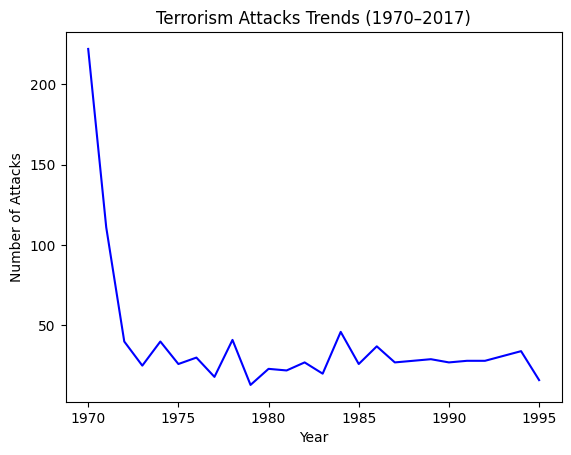


📊 EDA: REGION-WISE TREND


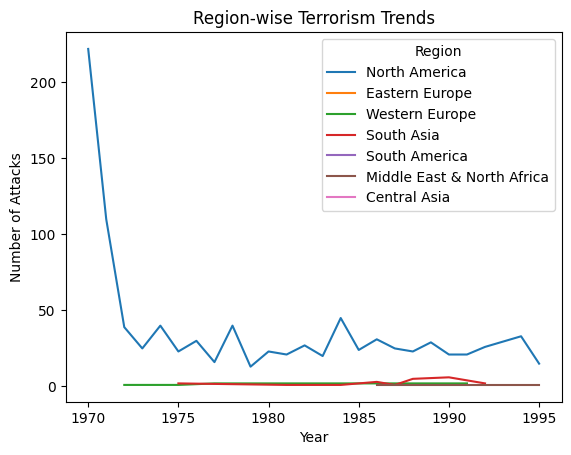


📊 EDA: TOP 10 AFFECTED COUNTRIES


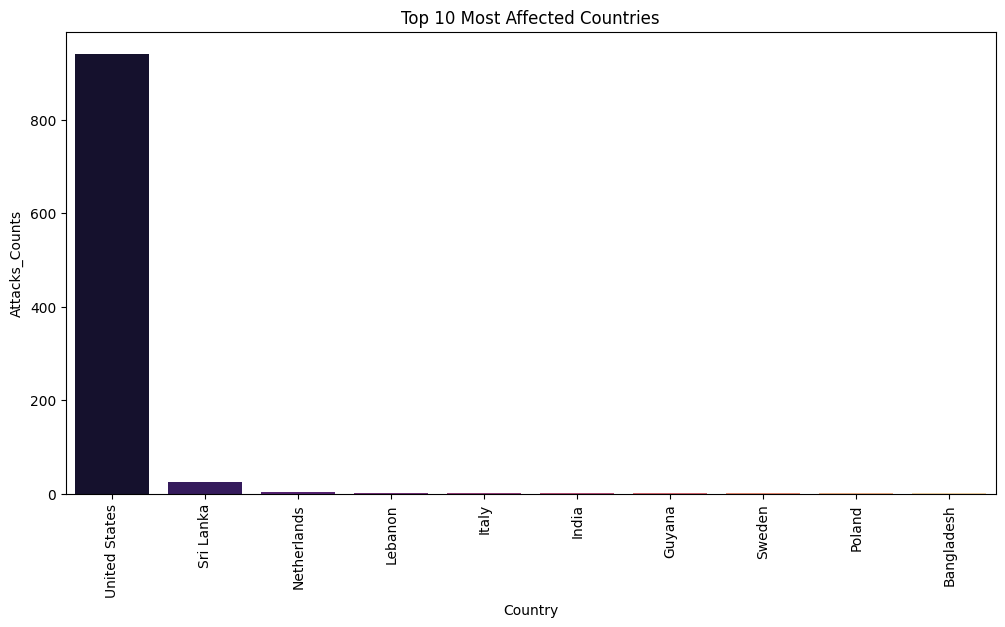


📊 EDA: REGION-WISE ATTACK COUNTS


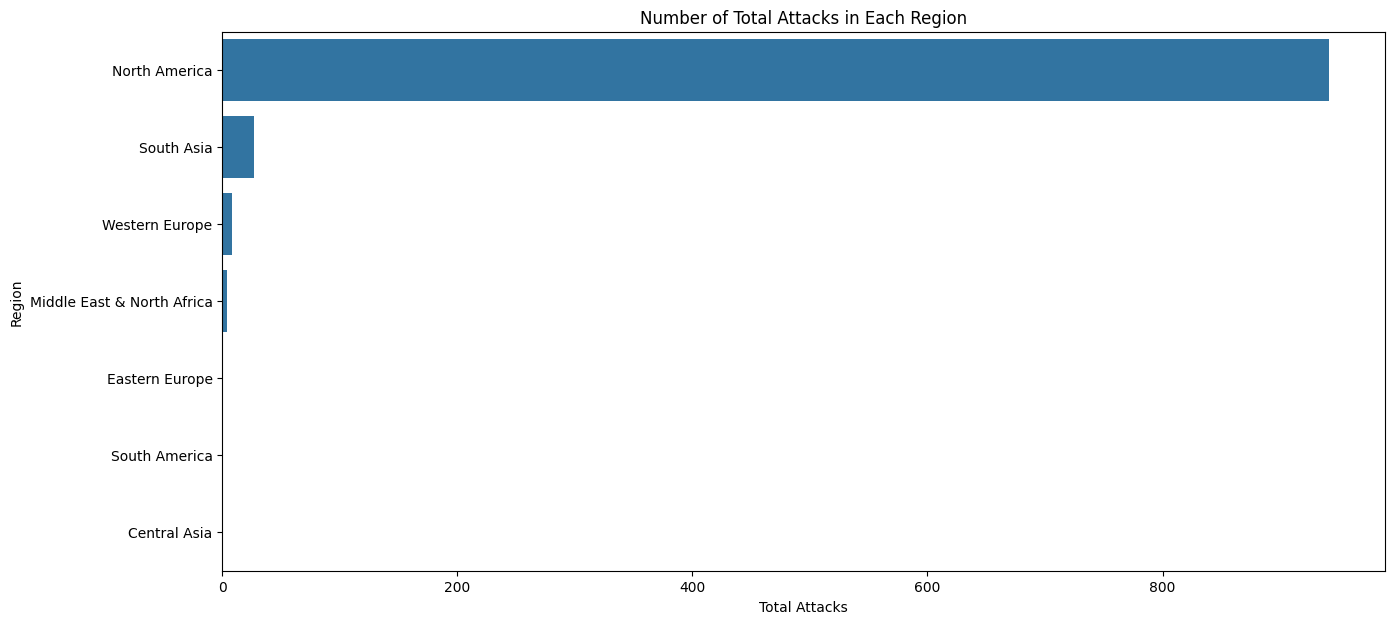

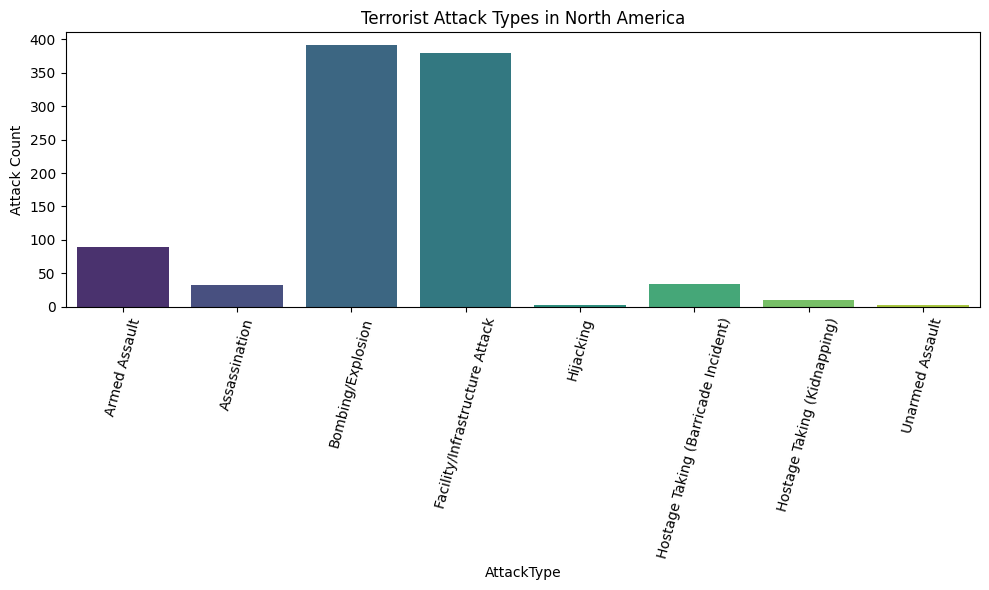

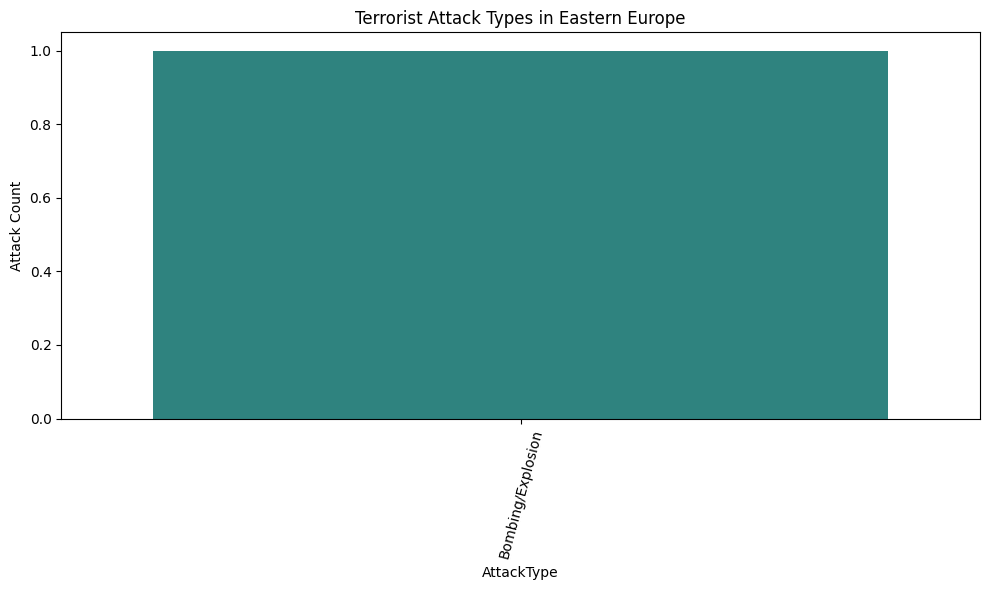

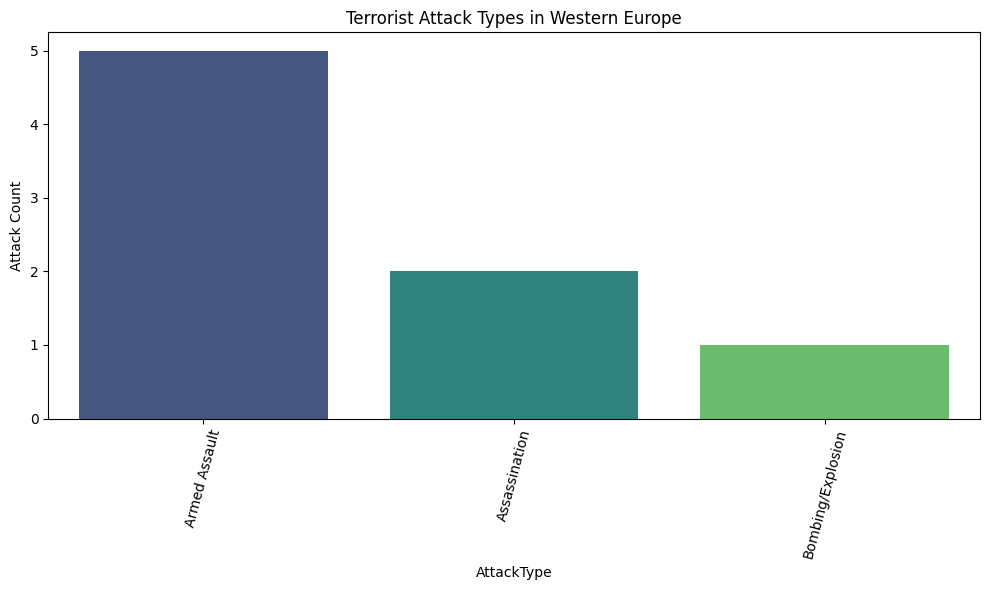

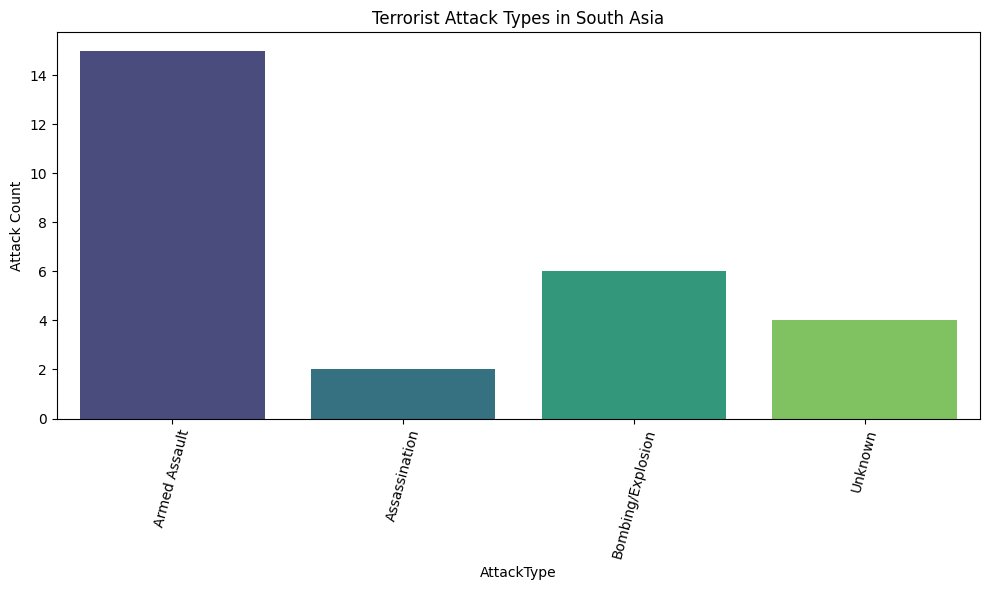

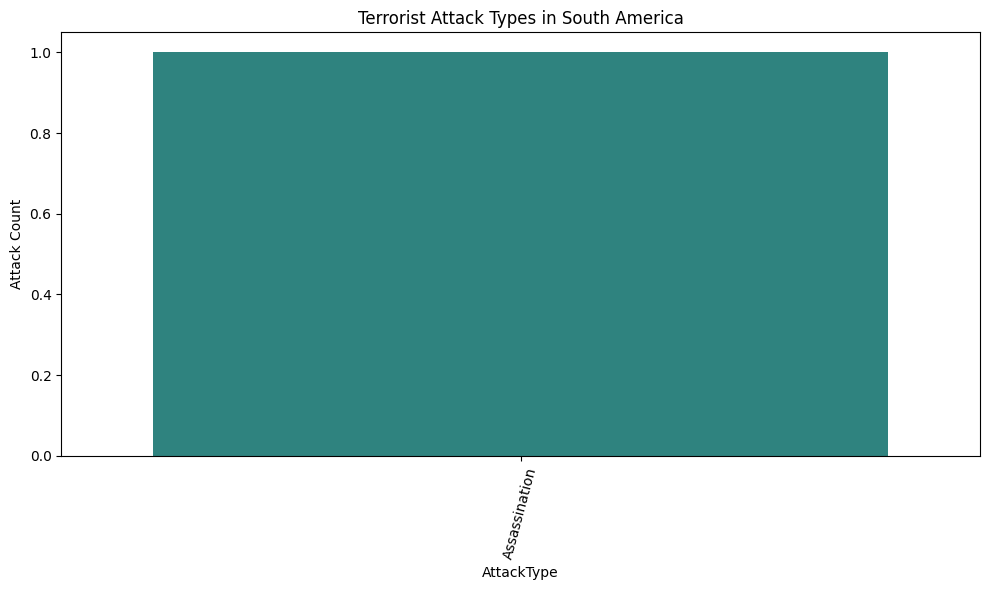

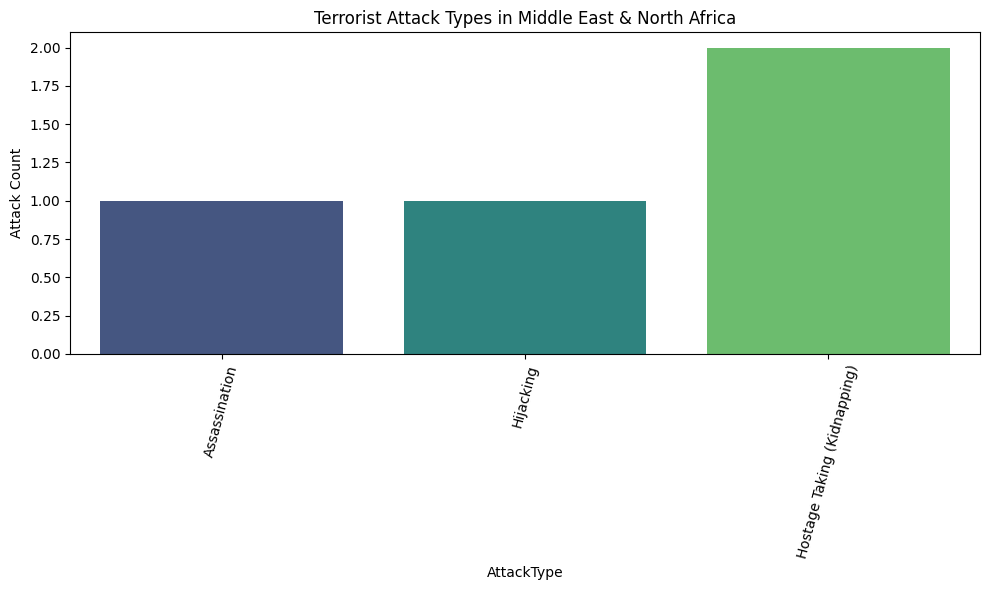

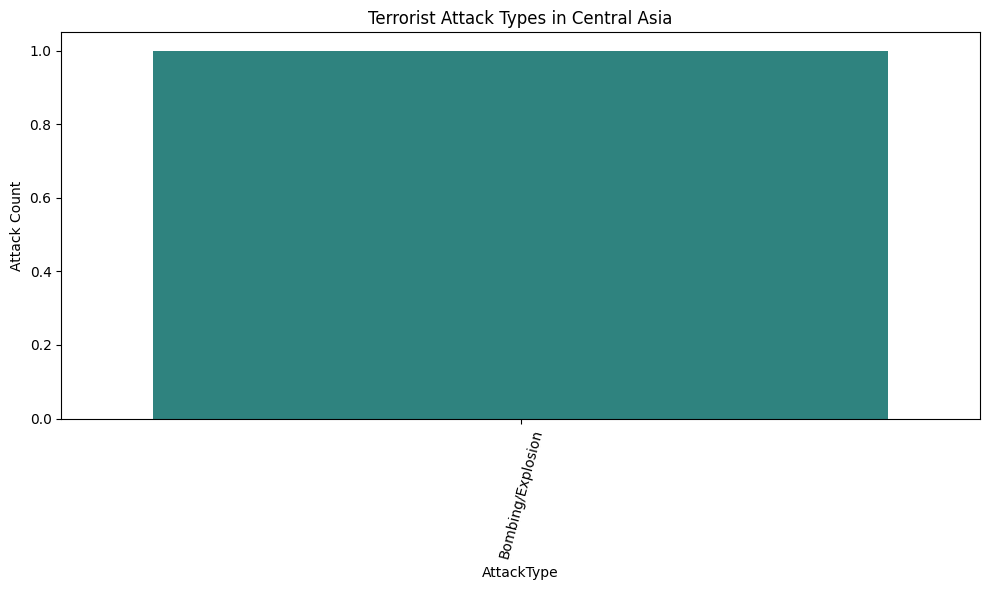


📊 EDA: TOP 5 TERRORIST GROUPS


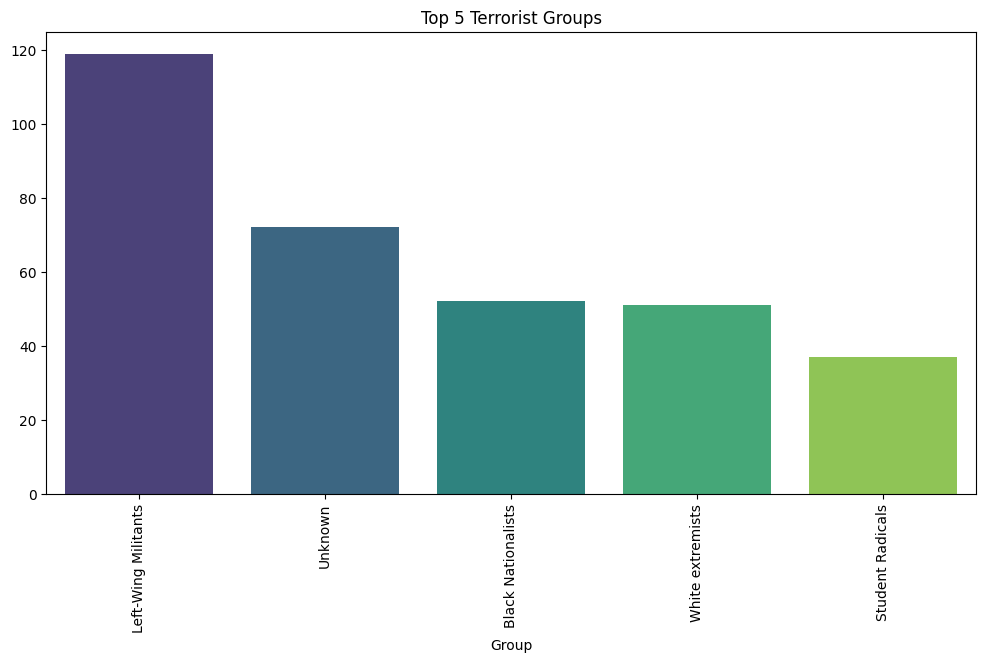


🗺️ Choropleth Map: Terrorist Attacks by Country



📊 SUCCESS RATE OF ATTACKS


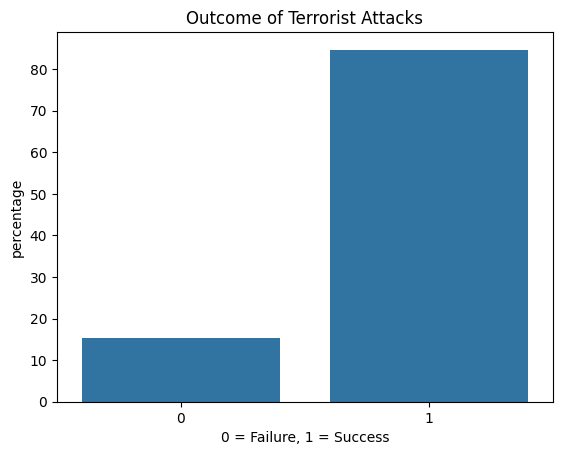

In [8]:

# ==============================
# 3️⃣ EDA VISUALIZATIONS
# ==============================
print("\n📊 EDA: YEARLY TREND OF ATTACKS")
year_attacks = df.groupby('Year').size().reset_index(name='count')
sns.lineplot(x='Year', y='count', data=year_attacks, color='blue')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.title("Terrorism Attacks Trends (1970–2017)")
plt.show()

print("\n📊 EDA: REGION-WISE TREND")
year_attacks_region = df.groupby(['Year','Region']).size().reset_index(name='count')
sns.lineplot(x='Year', y='count', hue='Region', data=year_attacks_region)
plt.title('Region-wise Terrorism Trends')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.show()

print("\n📊 EDA: TOP 10 AFFECTED COUNTRIES")
top = df['Country'].value_counts()[:10].reset_index()
top.columns= ['Country','Attacks_Counts']
plt.figure(figsize=(12,6))
sns.barplot(x='Country',y='Attacks_Counts', data=top, palette='magma')
plt.title('Top 10 Most Affected Countries')
plt.xticks(rotation=90)
plt.show()

print("\n📊 EDA: REGION-WISE ATTACK COUNTS")
region_attacks= df['Region'].value_counts().reset_index()
region_attacks.columns = ['Region', 'Total Attacks']
plt.figure(figsize=(15,7))
sns.barplot(x='Total Attacks', y='Region', data=region_attacks, orient='h')
plt.title('Number of Total Attacks in Each Region')
plt.show()

# Region Attack Type Distribution
region_attack_counts = df.groupby(['Region', 'AttackType']).size().reset_index(name='Attack Count')
for region in df.Region.unique():
    plt.figure(figsize=(10, 6))
    sns.barplot(data=region_attack_counts[region_attack_counts['Region'] == region],
                x='AttackType', y='Attack Count', palette="viridis")
    plt.title(f'Terrorist Attack Types in {region}')
    plt.xticks(rotation=75)
    plt.tight_layout()
    plt.show()

print("\n📊 EDA: TOP 5 TERRORIST GROUPS")
group_counts = df['Group'].value_counts().iloc[1:6]
plt.figure(figsize=(12, 6))
sns.barplot(x=group_counts.index, y=group_counts.values, palette="viridis")
plt.title('Top 5 Terrorist Groups')
plt.xticks(rotation=90)
plt.show()

print("\n🗺️ Choropleth Map: Terrorist Attacks by Country")
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Attack Count']
fig = px.choropleth(country_counts, locations='Country', locationmode='country names',
                    color='Attack Count', title='Terrorist Attacks by Country',
                    color_continuous_scale='Blues')
fig.show()

print("\n📊 SUCCESS RATE OF ATTACKS")
noa = df.groupby('Year').size().reset_index(name='count')
total_attacks = noa['count'].sum()
succ = df.groupby(['success']).size().reset_index(name='count')
succ['percentage'] = succ['count'] / total_attacks * 100
sns.barplot(x='success', y='percentage', data=succ)
plt.title("Outcome of Terrorist Attacks")
plt.xlabel("0 = Failure, 1 = Success")
plt.show()



🇮🇳 ANALYSIS FOR INDIA
Total Attacks in India: 1


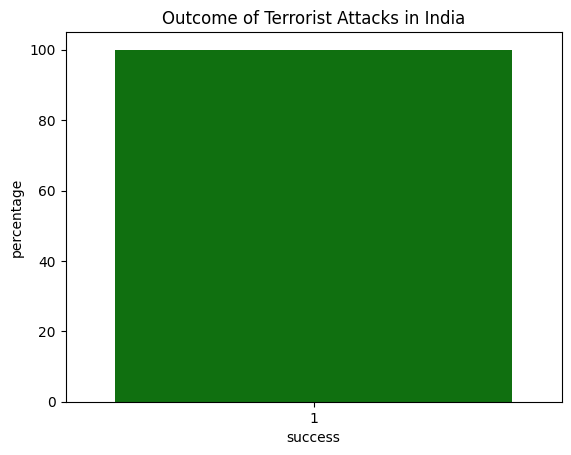

In [9]:

# ==============================
# 4️⃣ INDIA SPECIFIC ANALYSIS
# ==============================
print("\n🇮🇳 ANALYSIS FOR INDIA")
India = df[df['Country'] == 'India']
India_attacks = India['eventid'].count()
print(f"Total Attacks in India: {India_attacks}")
India_success = India.groupby('success').size().reset_index(name='count')
India_success['percentage'] = India_success['count'] / India_attacks * 100
sns.barplot(x='success', y='percentage', data=India_success, color='green')
plt.title("Outcome of Terrorist Attacks in India")
plt.show()


In [10]:

# ==============================
# 5️⃣ FEATURE ENCODING FOR ML
# ==============================
print("\n🔧 Encoding Features for ML...")

ml_df = df[['Year','Month','Day','Country','Region','AttackType','Killed','Wounded','Weapon_type','success']].copy()
ml_df[['Killed','Wounded']] = ml_df[['Killed','Wounded']].fillna(0)
label_cols = ['Country','Region','AttackType','Weapon_type']
le = LabelEncoder()
for col in label_cols:
    ml_df[col] = le.fit_transform(ml_df[col])

X = ml_df.drop('success', axis=1)
y = ml_df['success']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


🔧 Encoding Features for ML...



🔎 Performing PCA...


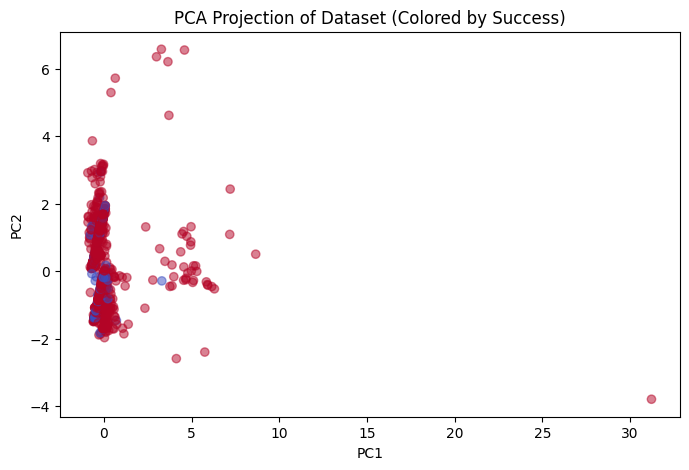

Explained Variance Ratio: [0.24077462 0.16963743]


In [11]:


# ==============================
# 6️⃣ PCA FOR VISUALIZATION
# ==============================
print("\n🔎 Performing PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.title("PCA Projection of Dataset (Colored by Success)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")


🤖 Training Logistic Regression Model...

📌 MODEL EVALUATION
Accuracy: 0.8514

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.85      1.00      0.92       252

    accuracy                           0.85       296
   macro avg       0.43      0.50      0.46       296
weighted avg       0.72      0.85      0.78       296


Confusion Matrix:
 [[  0  44]
 [  0 252]]


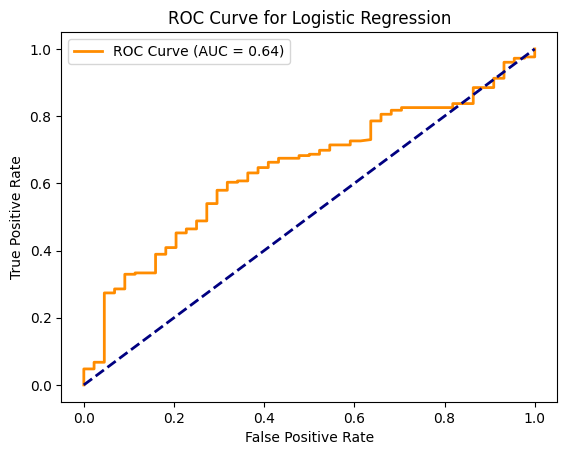

In [12]:


# ==============================
# 7️⃣ LOGISTIC REGRESSION
# ==============================
print("\n🤖 Training Logistic Regression Model...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n📌 MODEL EVALUATION")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()


In [13]:

# ==============================
# 8️⃣ RANDOM SAMPLE PREDICTIONS
# ==============================
print("\n🎲 Random Sample Predictions (10 rows):")
sample_idx = random.sample(range(len(X_test)), 10)
sample_data = X_test[sample_idx]
sample_actual = y_test.iloc[sample_idx]
sample_pred = model.predict(sample_data)
sample_prob = model.predict_proba(sample_data)[:,1]

sample_df = pd.DataFrame(sample_data, columns=X.columns)
sample_df['Actual Success'] = sample_actual.values
sample_df['Predicted Success'] = sample_pred
sample_df['Predicted Probability'] = sample_prob
print(sample_df)



🎲 Random Sample Predictions (10 rows):
       Year     Month       Day   Country   Region  AttackType    Killed  \
0 -0.936363  0.799615 -1.464565  0.171491 -0.16062   -0.259676 -0.136661   
1 -0.443580  0.799615 -1.127721  0.171491 -0.16062   -1.078653 -0.136661   
2  1.897141 -1.217875 -0.004907  0.171491 -0.16062    2.197255 -0.136661   
3 -0.443580  1.087828 -0.229469  0.171491 -0.16062   -0.259676 -0.136661   
4 -1.059559 -0.353236 -1.576847  0.171491 -0.16062   -0.259676 -0.136661   
5 -1.059559 -0.929662 -0.454032  0.171491 -0.16062    0.559301 -0.136661   
6  1.404357 -1.506088  1.679315  0.171491 -0.16062   -1.078653  0.108283   
7  1.404357  0.223189  1.117908 -2.058646  4.35509   -1.897629  2.067833   
8 -1.059559 -0.353236 -1.689128  0.171491 -0.16062    0.559301 -0.136661   
9 -1.059559 -0.929662  1.791596  0.171491 -0.16062   -0.259676 -0.136661   

    Wounded  Weapon_type  Actual Success  Predicted Success  \
0 -0.139478    -0.931401               0                  1 